<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#How-can-we-restore-disorganized-chapters-to-their-original-books?" data-toc-modified-id="How-can-we-restore-disorganized-chapters-to-their-original-books?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>How can we restore disorganized chapters to their original books?</a></span></li><li><span><a href="#Latent-Dirichlet-Allocation-with-the-topicmodels-package" data-toc-modified-id="Latent-Dirichlet-Allocation-with-the-topicmodels-package-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Latent Dirichlet Allocation with the topicmodels package</a></span></li><li><span><a href="#Per-document-classification" data-toc-modified-id="Per-document-classification-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Per-document classification</a></span></li><li><span><a href="#Which-chapters-were-misidentified?" data-toc-modified-id="Which-chapters-were-misidentified?-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Which chapters were misidentified?</a></span></li><li><span><a href="#By-word-assignments:-augment" data-toc-modified-id="By-word-assignments:-augment-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>By word assignments: augment</a></span></li><li><span><a href="#What-were-the-most-commonly-mistaken-words?" data-toc-modified-id="What-were-the-most-commonly-mistaken-words?-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>What were the most commonly mistaken words?</a></span></li><li><span><a href="#Case-study:-mining-NASA-metadata" data-toc-modified-id="Case-study:-mining-NASA-metadata-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Case study: mining NASA metadata</a></span></li><li><span><a href="#How-data-is-organized-at-NASA" data-toc-modified-id="How-data-is-organized-at-NASA-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>How data is organized at NASA</a></span><ul class="toc-item"><li><span><a href="#Wrangling-and-tidying-the-data" data-toc-modified-id="Wrangling-and-tidying-the-data-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Wrangling and tidying the data</a></span></li></ul></li></ul></div>

https://cran.r-project.org/web/packages/tidytext/vignettes/topic_modeling.html

- Topic modeling is a method for unsupervised classification of documents, by modeling each document as a mixture of topics and each topic as a mixture of words. Latent Dirichlet allocation is a particularly popular method for fitting a topic model: https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation.

- We can use tidy text principles, as described in the main vignette (https://cran.r-project.org/web/packages/tidytext/vignettes/tidytext.html), to approach topic modeling. In particular, we’ll be using **tidying functions for LDA objects** from the `topicmodels` package: https://cran.r-project.org/web/packages/topicmodels/index.html.

## How can we restore disorganized chapters to their original books?
- Great Expectations by Charles Dickens
- The War of the Worlds by H.G. Wells
- Twenty Thousand Leagues Under the Sea by Jules Verne
- Pride and Prejudice by Jane Austen

In [2]:
library(dplyr)
library(gutenbergr)
titles <- c("Twenty Thousand Leagues under the Sea", "The War of the Worlds",
            "Pride and Prejudice", "Great Expectations")
books <- gutenberg_works(title %in% titles) %>% gutenberg_download(meta_fields = "title")

In [5]:
head(books)
tail(books)

gutenberg_id,text,title
36,The War of the Worlds,The War of the Worlds
36,,The War of the Worlds
36,by H. G. Wells [1898],The War of the Worlds
36,,The War of the Worlds
36,,The War of the Worlds
36,But who shall dwell in these worlds if they be,The War of the Worlds


gutenberg_id,text,title
1400,"""And will continue friends apart,"" said Estella.",Great Expectations
1400,,Great Expectations
1400,"I took her hand in mine, and we went out of the ruined place; and, as",Great Expectations
1400,"the morning mists had risen long ago when I first left the forge, so the",Great Expectations
1400,"evening mists were rising now, and in all the broad expanse of tranquil",Great Expectations
1400,"light they showed to me, I saw no shadow of another parting from her.",Great Expectations


In [7]:
str(books)

Classes 'tbl_df', 'tbl' and 'data.frame':	51663 obs. of  3 variables:
 $ gutenberg_id: int  36 36 36 36 36 36 36 36 36 36 ...
 $ text        : chr  "The War of the Worlds" "" "by H. G. Wells [1898]" "" ...
 $ title       : chr  "The War of the Worlds" "The War of the Worlds" "The War of the Worlds" "The War of the Worlds" ...


As pre-processing, we divide these into chapters, use tidytext’s `unnest_tokens` to separate them into words, then remove `stop_words`. We’re treating every chapter as a separate “document”, each with a name like Great Expectations_1 or Pride and Prejudice_11.

In [13]:
library(tidytext)
library(stringr)
library(tidyr)
# add column indicating from which chapter each line of text comes from
books %>% group_by(title) %>% mutate(chapter = cumsum(str_detect(text, regex("^chapter ", ignore_case = TRUE)))) %>% head(3)

gutenberg_id,text,title,chapter
36,The War of the Worlds,The War of the Worlds,0
36,,The War of the Worlds,0
36,by H. G. Wells [1898],The War of the Worlds,0


In [10]:
by_chapter <- books %>%
              group_by(title) %>%
              mutate(chapter = cumsum(str_detect(text, regex("^chapter ", ignore_case = TRUE)))) %>%
              ungroup() %>%
              filter(chapter > 0) # to eliminate forword, introduction etc. and start with chapter 1
head(by_chapter)

gutenberg_id,text,title,chapter
36,CHAPTER ONE,The War of the Worlds,1
36,,The War of the Worlds,1
36,THE EVE OF THE WAR,The War of the Worlds,1
36,,The War of the Worlds,1
36,,The War of the Worlds,1
36,No one would have believed in the last years of the nineteenth,The War of the Worlds,1


In [12]:
by_chapter %>% unite(title_chapter, title, chapter) %>% head(3) # combine title + chapter into col title_chapter

gutenberg_id,text,title_chapter
36,CHAPTER ONE,The War of the Worlds_1
36,,The War of the Worlds_1
36,THE EVE OF THE WAR,The War of the Worlds_1


In [14]:
by_chapter_word <- by_chapter %>% unite(title_chapter, title, chapter) %>%
                        unnest_tokens(word, text) # unnest into word from text
head(by_chapter_word, 3)

gutenberg_id,title_chapter,word
36,The War of the Worlds_1,chapter
36,The War of the Worlds_1,one
36,The War of the Worlds_1,the


In [15]:
by_chapter_word %>% anti_join(stop_words) %>%
              count(title_chapter, word, sort = TRUE) %>% head(2)

Joining, by = "word"


title_chapter,word,n
Great Expectations_57,joe,88
Great Expectations_7,joe,70


In [16]:
word_counts <- by_chapter_word %>%
                  anti_join(stop_words) %>%
                  count(title_chapter, word, sort = TRUE) %>%
                  ungroup() # no effect now, but important for later pipes
head(word_counts)

Joining, by = "word"


title_chapter,word,n
Great Expectations_57,joe,88
Great Expectations_7,joe,70
Great Expectations_17,biddy,63
Great Expectations_27,joe,58
Great Expectations_38,estella,58
Great Expectations_2,joe,56


## Latent Dirichlet Allocation with the topicmodels package
Right now this data frame is in a tidy form, with `one-term-per-document-per-row`. However, the `topicmodels` package requires a `tm::DocumentTermMatrix`. We can **cast a one-token-per-row table into a DocumentTermMatrix** with `tidytext::cast_dtm`:

In [17]:
chapters_dtm <- word_counts %>% cast_dtm(title_chapter, word, n)
chapters_dtm

<<DocumentTermMatrix (documents: 193, terms: 18215)>>
Non-/sparse entries: 104722/3410773
Sparsity           : 97%
Maximal term length: 19
Weighting          : term frequency (tf)

Now we are ready to use the topicmodels package to **create a four topic LDA model**.

In [18]:
library(topicmodels)
chapters_lda <- LDA(chapters_dtm, k = 4, control = list(seed = 1234))
chapters_lda

Warning message:
"package 'topicmodels' was built under R version 3.4.4"

A LDA_VEM topic model with 4 topics.

- In this case **we know there are four topics because there are four books**; in practice **we may need to try a few different values of k**.
- tidytext gives us the option of returning to a tidy analysis, using the `tidy` and `augment` verbs borrowed from the `broom` package. In particular, we start with the tidy verb.

In [20]:
chapters_lda_td <- tidy(chapters_lda)
head(chapters_lda_td)
str(chapters_lda_td)

topic,term,beta
1,joe,1.436612e-17
2,joe,5.962111e-61
3,joe,9.881855e-25
4,joe,1.447329e-02
1,biddy,5.139275e-28
2,biddy,5.022015e-73


Classes 'tbl_df', 'tbl' and 'data.frame':	72860 obs. of  3 variables:
 $ topic: int  1 2 3 4 1 2 3 4 1 2 ...
 $ term : chr  "joe" "joe" "joe" "joe" ...
 $ beta : num  1.44e-17 5.96e-61 9.88e-25 1.45e-02 5.14e-28 ...


- this has turned the model into a `one-topic-per-term-per-row` format. For each combination the model has **β = probability of that term being generated from that topic**.
- We could use dplyr’s `top_n` to find the top 5 terms within each topic:

In [21]:
chapters_lda_td %>% group_by(topic) %>% top_n(5, beta)

topic,term,beta
4,joe,0.014473289
1,miss,0.008708777
4,miss,0.006232761
1,elizabeth,0.014101270
2,captain,0.015510635
2,nautilus,0.013051927
1,darcy,0.008810341
2,sea,0.008843483
4,pip,0.006828209
2,ned,0.008031955


In [22]:
top_terms <- chapters_lda_td %>% group_by(topic) %>% top_n(5, beta) %>%
              ungroup() %>% arrange(topic, -beta) # ORDER the output from above BY topic ASC a. beta DESC

top_terms

topic,term,beta
1,elizabeth,0.014101270
1,darcy,0.008810341
1,miss,0.008708777
1,bennet,0.006944344
1,jane,0.006494613
2,captain,0.015510635
2,nautilus,0.013051927
2,sea,0.008843483
2,nemo,0.008709651
2,ned,0.008031955


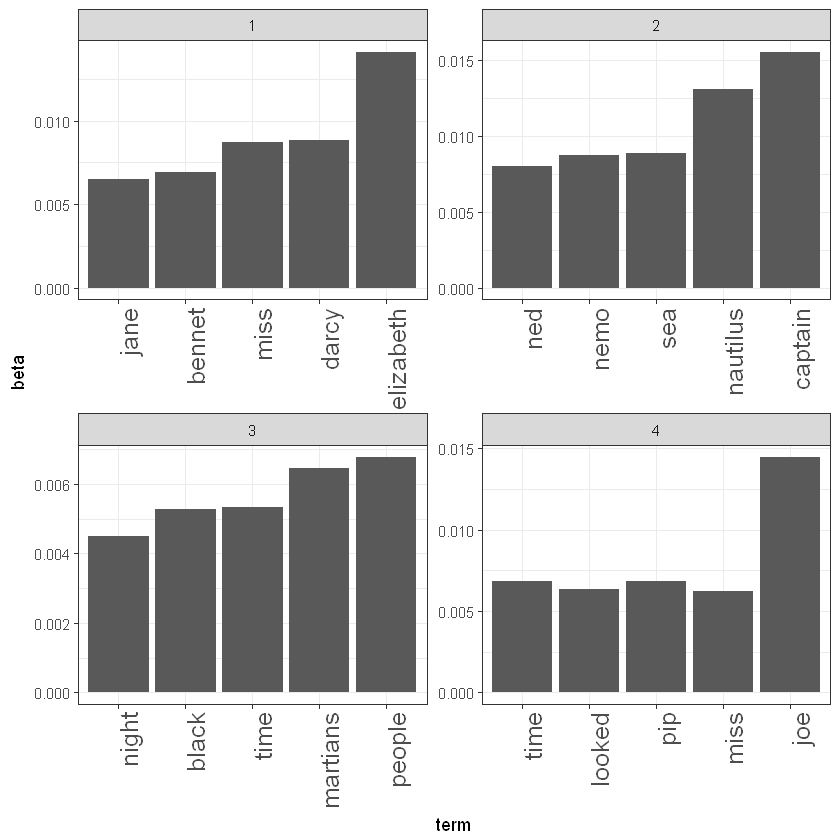

In [24]:
# This model lends itself to a visualization:
library(ggplot2)
theme_set(theme_bw())

top_terms %>% mutate(term = reorder(term, beta)) %>% # does nothing
  ggplot(aes(term, beta)) +
  geom_bar(stat = "identity") + # If you want heights of bars to represent values in the data 
# (you need to map a value to the y aesthetic) - without this stat = "identity" plot returns an error
  facet_wrap(~ topic, scales = "free") + # free cause scales vary across rows and columns
  theme(axis.text.x = element_text(size = 15, angle = 90, hjust = 1))

## Per-document classification
Each chapter was a “document” in this analysis. Thus, we may want to know which topics are associated with each document. **Can we put the chapters back together in the correct books?**

In [27]:
chapters_lda_gamma <- tidy(chapters_lda, matrix = "gamma")
head(chapters_lda_gamma)
tail(chapters_lda_gamma)

document,topic,gamma
Great Expectations_57,1,1.338547e-05
Great Expectations_7,1,1.456215e-05
Great Expectations_17,1,2.096237e-05
Great Expectations_27,1,1.900804e-05
Great Expectations_38,1,3.552749e-01
Great Expectations_2,1,1.706715e-05


document,topic,gamma
Pride and Prejudice_5,4,6.485469e-05
Pride and Prejudice_60,4,4.068034e-05
Pride and Prejudice_12,4,8.029132e-05
The War of the Worlds_3,4,5.096009e-05
The War of the Worlds_7,4,4.177962e-05
Twenty Thousand Leagues under the Sea_46,4,1.188746e-04


Setting `matrix = "gamma"` returns a tidied version with one-document-per-topic-per-row. 
- Now that we have these document classifications, we can see **how well our unsupervised learning did at distinguishing the four books**. 
- First we **re-separate** the document name **into title and chapter**:

In [28]:
chapters_lda_gamma <- chapters_lda_gamma %>% separate(document, c("title", "chapter"), sep = "_", convert = TRUE)
head(chapters_lda_gamma)
str(chapters_lda_gamma)

title,chapter,topic,gamma
Great Expectations,57,1,1.338547e-05
Great Expectations,7,1,1.456215e-05
Great Expectations,17,1,2.096237e-05
Great Expectations,27,1,1.900804e-05
Great Expectations,38,1,3.552749e-01
Great Expectations,2,1,1.706715e-05


Classes 'tbl_df', 'tbl' and 'data.frame':	772 obs. of  4 variables:
 $ title  : chr  "Great Expectations" "Great Expectations" "Great Expectations" "Great Expectations" ...
 $ chapter: int  57 7 17 27 38 2 23 15 18 16 ...
 $ topic  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ gamma  : num  1.34e-05 1.46e-05 2.10e-05 1.90e-05 3.55e-01 ...


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


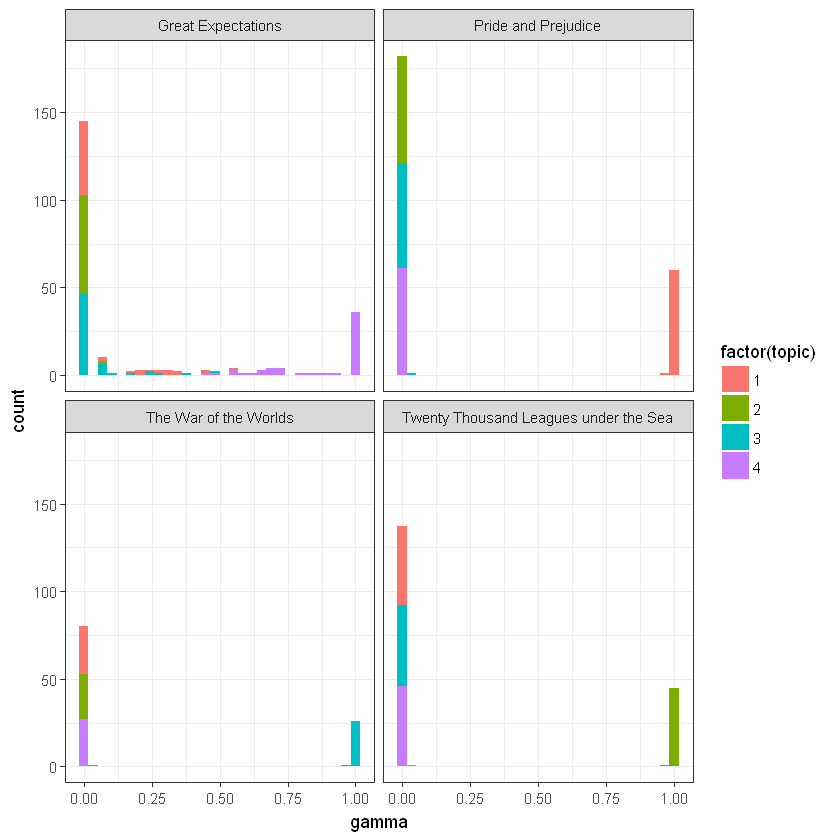

In [29]:
# Then we examine what fraction of chapters we got right for each:
ggplot(chapters_lda_gamma, aes(gamma, fill = factor(topic))) + geom_histogram() + facet_wrap(~ title, nrow = 2)

We notice that almost all of the chapters from top right & both at the bottom were **uniquely identified as a single topic each**.

In [31]:
chapter_classifications <- chapters_lda_gamma %>% group_by(title, chapter) %>%
                              top_n(1, gamma) %>% ungroup() %>% arrange(gamma)
head(chapter_classifications)
str(chapter_classifications)

title,chapter,topic,gamma
Great Expectations,54,3,0.4812041
Great Expectations,22,4,0.5362582
Great Expectations,23,1,0.5470853
Great Expectations,31,4,0.5473876
Great Expectations,33,4,0.5689223
Great Expectations,47,4,0.5799048


Classes 'tbl_df', 'tbl' and 'data.frame':	193 obs. of  4 variables:
 $ title  : chr  "Great Expectations" "Great Expectations" "Great Expectations" "Great Expectations" ...
 $ chapter: int  54 22 23 31 33 47 56 38 3 11 ...
 $ topic  : int  3 4 1 4 4 4 4 4 4 4 ...
 $ gamma  : num  0.481 0.536 0.547 0.547 0.569 ...


We can determine this by finding the consensus book for each, which we note is correct based on our earlier visualization:

In [32]:
chapter_classifications %>% count(title, topic) %>% top_n(1, n) %>% ungroup()

title,topic,n
Pride and Prejudice,1,61


In [33]:
book_topics <- chapter_classifications %>% count(title, topic) %>% top_n(1, n) %>% ungroup() %>%
                transmute(consensus = title, topic) # Adds new variable consensus and drops title and topic 
book_topics

consensus,topic
Pride and Prejudice,1


## Which chapters were misidentified?

In [34]:
chapter_classifications %>% inner_join(book_topics, by = "topic") %>% count(title, consensus)

title,consensus,n
Great Expectations,Pride and Prejudice,1
Pride and Prejudice,Pride and Prejudice,61


We see that only a few chapters from Great Expectations were misclassified. Not bad for unsupervised clustering!

## By word assignments: augment
One important step in the topic modeling expectation-maximization algorithm is **assigning each word in each document to a topic**. 
- The more words in a document are assigned to a topic, the more weight (`gamma`) will go on that document-topic classification.
- We may want to take the original document-word pairs and find which words in each document were assigned to which topic. This is the job of the `augment`.

In [35]:
assignments <- augment(chapters_lda, data = chapters_dtm)
str(assignments)

Classes 'tbl_df', 'tbl' and 'data.frame':	104722 obs. of  4 variables:
 $ document: chr  "Great Expectations_57" "Great Expectations_7" "Great Expectations_17" "Great Expectations_27" ...
 $ term    : chr  "joe" "joe" "joe" "joe" ...
 $ count   : num  88 70 5 58 56 1 50 50 44 40 ...
 $ .topic  : num  4 4 4 4 4 4 4 4 4 4 ...


We can combine this with the consensus book titles to find which words were incorrectly classified.

In [36]:
assignments <- assignments %>% separate(document, c("title", "chapter"), sep = "_", convert = TRUE) %>%
                      inner_join(book_topics, by = c(".topic" = "topic"))
head(assignments)
str(assignments)

title,chapter,term,count,.topic,consensus
Pride and Prejudice,47,pocket,1,1,Pride and Prejudice
Pride and Prejudice,50,pocket,1,1,Pride and Prejudice
Pride and Prejudice,49,pocket,1,1,Pride and Prejudice
Great Expectations,38,brother,2,1,Pride and Prejudice
Pride and Prejudice,43,brother,4,1,Pride and Prejudice
Pride and Prejudice,18,brother,1,1,Pride and Prejudice


Classes 'tbl_df', 'tbl' and 'data.frame':	29412 obs. of  6 variables:
 $ title    : chr  "Pride and Prejudice" "Pride and Prejudice" "Pride and Prejudice" "Great Expectations" ...
 $ chapter  : int  47 50 49 38 43 18 22 45 16 10 ...
 $ term     : chr  "pocket" "pocket" "pocket" "brother" ...
 $ count    : num  1 1 1 2 4 1 4 2 1 2 ...
 $ .topic   : num  1 1 1 1 1 1 1 1 1 1 ...
 $ consensus: chr  "Pride and Prejudice" "Pride and Prejudice" "Pride and Prejudice" "Pride and Prejudice" ...


We can, for example, create a “confusion matrix” using `dplyr::count` and `tidyr::spread`:

In [37]:
assignments %>% count(title, consensus, wt = count) %>% spread(consensus, n, fill = 0)

title,Pride and Prejudice
Great Expectations,3908
Pride and Prejudice,37231
Twenty Thousand Leagues under the Sea,5


We notice that almost all the words for Pride and Prejudice, Twenty Thousand (*only 5 misclassifications*), and War of the Worlds (*perfectly assigned*) were **correctly assigned**, while Great Expectations was 3908 times misassigned as Pride and Prejudice.

## What were the most commonly mistaken words?

In [38]:
wrong_words <- assignments %>% filter(title != consensus)
head(wrong_words)
str(wrong_words)

title,chapter,term,count,.topic,consensus
Great Expectations,38,brother,2,1,Pride and Prejudice
Great Expectations,22,brother,4,1,Pride and Prejudice
Great Expectations,23,miss,2,1,Pride and Prejudice
Great Expectations,22,miss,23,1,Pride and Prejudice
Twenty Thousand Leagues under the Sea,8,miss,1,1,Pride and Prejudice
Great Expectations,31,miss,1,1,Pride and Prejudice


Classes 'tbl_df', 'tbl' and 'data.frame':	3140 obs. of  6 variables:
 $ title    : chr  "Great Expectations" "Great Expectations" "Great Expectations" "Great Expectations" ...
 $ chapter  : int  38 22 23 22 8 31 5 22 31 23 ...
 $ term     : chr  "brother" "brother" "miss" "miss" ...
 $ count    : num  2 4 2 23 1 1 37 3 2 10 ...
 $ .topic   : num  1 1 1 1 1 1 1 1 1 1 ...
 $ consensus: chr  "Pride and Prejudice" "Pride and Prejudice" "Pride and Prejudice" "Pride and Prejudice" ...


In [40]:
wrong_words %>% count(title, consensus, term, wt = count) %>% ungroup() %>% arrange(desc(n)) %>% head(10)

title,consensus,term,n
Great Expectations,Pride and Prejudice,love,44
Great Expectations,Pride and Prejudice,sergeant,37
Great Expectations,Pride and Prejudice,lady,32
Great Expectations,Pride and Prejudice,miss,26
Great Expectations,Pride and Prejudice,father,19
Great Expectations,Pride and Prejudice,baby,18
Great Expectations,Pride and Prejudice,flopson,18
Great Expectations,Pride and Prejudice,family,16
Great Expectations,Pride and Prejudice,replied,16
Great Expectations,Pride and Prejudice,attention,14


Notice the word **“flopson”** here; these **wrong words do not necessarily appear in the novels they were misassigned to**. Indeed, we can confirm “flopson” appears only in Great Expectations:

In [41]:
word_counts %>% filter(word == "flopson")

title_chapter,word,n
Great Expectations_22,flopson,10
Great Expectations_23,flopson,7
Great Expectations_33,flopson,1


The algorithm is stochastic and iterative, and it can accidentally land on a topic that spans multiple books.

## Case study: mining NASA metadata
https://www.tidytextmining.com/nasa.html


In [1]:
library(ggplot2)
library(methods)
theme_set(theme_light())

There are over 32,000 datasets hosted and/or maintained by [NASA](https://www.nasa.gov/); 
- these datasets cover **topics from Earth science to aerospace engineering to management of NASA itself**. We can use the metadata for these datasets to understand the connections between them. 
- The metadata includes information like the title of the dataset, a description field, what **organization(s)** within NASA is responsible for the dataset, **keywords** for the dataset that have been assigned by a human being, and so forth. 
- NASA places a high priority on making its data open and accessible, even requiring all NASA-funded research to be [openly accessible online](https://www.nasa.gov/press-release/nasa-unveils-new-public-web-portal-for-research-results). The metadata for all its datasets is [publicly available online in JSON format](https://data.nasa.gov/data.json).
- **We will treat the NASA metadata as a text dataset**: 
    - word co-occurrences 
    - correlations, 
    - tf-idf,
    - topic modeling **to explore the connections between the datasets**: find datasets that are related to each other (=find clusters of similar datasets)
- text fields: 
    - title, description, keyword

## How data is organized at NASA
let's download the JSON file and take a look at the names of what is stored in the metadata.

In [1]:
#library(jsonlite)
#metadata <- fromJSON("https://data.nasa.gov/data.json")
load("data/metadata.rda")
names(metadata$dataset)

[1] "_id"                "@type"              "accessLevel"       
 [4] "accrualPeriodicity" "bureauCode"         "contactPoint"      
 [7] "description"        "distribution"       "identifier"        
[10] "issued"             "keyword"            "landingPage"       
[13] "language"           "modified"           "programCode"       
[16] "publisher"          "spatial"            "temporal"          
[19] "theme"              "title"              "license"           
[22] "isPartOf"           "references"         "rights"            
[25] "describedBy"

- we could extract information from **who publishes each dataset** to what license they are released under. 
- title, description, keywords are best for drawing connections between datasets.

In [2]:
class(metadata$dataset$title)
class(metadata$dataset$description)

[1] "character"

[1] "character"

[1] "list"

title & description - stored as character vectors, keywords - stored as a list of character vectors.
### Wrangling and tidying the data
Let's set up separate tidy data frames for title, description, and keyword, keeping the dataset ids for each so that we can connect them later if necessary.

In [2]:
library(dplyr)
nasa_title <- data_frame(id = metadata$dataset$`_id`$`$oid`, title = metadata$dataset$title)
head(nasa_title) # there are duplicate titles on separate datasets
str(nasa_title)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



id,title
55942a57c63a7fe59b495a77,15 Minute Stream Flow Data: USGS (FIFE)
55942a57c63a7fe59b495a78,15 Minute Stream Flow Data: USGS (FIFE)
55942a58c63a7fe59b495a79,15 Minute Stream Flow Data: USGS (FIFE)
55942a58c63a7fe59b495a7a,2000 Pilot Environmental Sustainability Index (ESI)
55942a58c63a7fe59b495a7b,2000 Pilot Environmental Sustainability Index (ESI)
55942a58c63a7fe59b495a7c,2000 Pilot Environmental Sustainability Index (ESI)


Classes 'tbl_df', 'tbl' and 'data.frame':	32089 obs. of  2 variables:
 $ id   : chr  "55942a57c63a7fe59b495a77" "55942a57c63a7fe59b495a78" "55942a58c63a7fe59b495a79" "55942a58c63a7fe59b495a7a" ...
 $ title: chr  "15 Minute Stream Flow Data: USGS (FIFE)" "15 Minute Stream Flow Data: USGS (FIFE)" "15 Minute Stream Flow Data: USGS (FIFE)" "2000 Pilot Environmental Sustainability Index (ESI)" ...


In [3]:
nasa_desc <- data_frame(id = metadata$dataset$`_id`$`$oid`, desc = metadata$dataset$description)
nasa_desc %>% select(desc) %>% sample_n(5)

desc
"Coherent Logix, Incorporated proposes the Software Defined Common Processing System (SDCPS) program to facilitate the development of a Software Defined Radio development kit based on HyperX Technology with an accompanying software development flow to support rapid development and fielding of this technology to NASA and high reliability system integrators. NASA's exploration, science, and space operations systems are critically dependent on the hardware technologies used in their implementation. Specifically, the performance and deployment of autonomous and computationally-intensive capabilities for space based observatories, orbiters, autonomous landing and hazard avoidance, autonomous rendezvous and capture, robotic, relative navigation, command, control and communications systems are directly dependent on the availability of radiation-tolerant, high-performance, reconfigurable and adaptable, modern communications and underlying energy-efficient processor technology. The HyperX Technology will simultaneously enable order of magnitude improvement in power savings while reducing chipset count, thus size and weight of the radio. The HyperX processor technology is fully programmable and reconfigurable on the fly and is supported by industry standards based [hardware agnostic software development flow and] programming model using ANSI-C and MPI (message passing interface) API. This provides reduced life-cycle costs and future proofing of hardware through fully portable software code."
The land water content data used to create these images were generated from The Global Land Data Assimilation System (GLDAS).
"MODIS (or Moderate Resolution Imaging Spectroradiometer) is a key instrument aboard the Terra (EOS AM) and Aqua (EOS PM) satellites. Terra's orbit around the Earth is timed so that it passes from north to south across the equator in the morning, while Aqua passes south to north over the equator in the afternoon. Terra MODIS and Aqua MODIS are viewing the entire Earth's surface every 1 to 2 days, acquiring data in 36 spectral bands, or groups of wavelengths (see MODIS Technical Specifications). These data will improve our understanding of global dynamics and processes occurring on the land, in the oceans, and in the lower atmosphere. MODIS is playing a vital role in the development of validated, global, interactive Earth system models able to predict global change accurately enough to assist policy makers in making sound decisions concerning the protection of our environment."
"The Coastal Zone Color Scanner Experiment (CZCS) was the first instrument devoted to the measurement of ocean color and flown on a spacecraft. Although other instruments flown on other spacecraft had sensed ocean color, their spectral bands, spatial resolution and dynamic range were optimized for land or meteorological use and had limited sensitivity in this area, whereas in CZCS, every parameter was optimized for use over water to the exclusion of any other type of sensing. CZCS had six spectral bands, four of which were used primarily for ocean color. These were of a 20 nanometer bandwidth centered at 443, 520, 550, and 670 nm. Band 5 had a 100 nm bandwidth centered at 750 nm and a dynamic range more suited to land. Band 6 operated in the 10.5 to 12.5 micrometer region and sensed emitted thermal radiance for derivation of equivalent black body temperature. (This thermal band failed within the first year of the mission, and so was not used in the global processing effort.) Bands 1-4 were preset to view water only and saturated when the IFOV was over most types of land surfaces, or clouds. The most important objective of the Coastal Zone Color Scanner mission was to determine if satellite remote sensing of color could be used to identify and quantify material suspended or dissolved in ocean waters. Specifically CZCS attempted to discriminate between organic and inorganic materials in the water, determine the quantity of material and discriminate b

Here we see the first part of several selected description fields from the metadata.
Now we can build the tidy data frame for the keywords. For this one, we need to use `unnest()` from tidyr, because they are in a list-column.

In [ ]:
library(tidyr)

In [ ]:
nasa_keyword <- data_frame(id = metadata$dataset$`_id`$`$oid`, keyword = metadata$dataset$keyword) %>% unnest(keyword)
head(nasa_keyword)
str(nasa_keyword)

This is a tidy data frame because we have one row for each keyword; this means we will have multiple rows for each dataset because a dataset can have more than one keyword.
Now it is time to use tidytext's `unnest_tokens()` for the title and description fields so we can do the text analysis. Let's also remove stop words from the titles and descriptions. We will not remove stop words from the keywords, because those are short, human-assigned keywords like "RADIATION" or "CLIMATE INDICATORS".

In [ ]:
library(tidytext)
nasa_title <- nasa_title %>% unnest_tokens(word, title) %>% anti_join(stop_words)
head(nasa_title)
str(nasa_title)

These are now in the tidy text format that we have been working with throughout this book, with one token (word, in this case) per row; let's take a look before we move on in our analysis.

In [ ]:
nasa_desc <- nasa_desc %>% unnest_tokens(word, desc) %>% anti_join(stop_words)
nasa_desc

In [ ]:
### Some initial simple exploration
What are the most common words in the NASA dataset titles? We can use `count()` from dplyr to check this out.

```{r dependson = "unnest"}
nasa_title %>% count(word, sort = TRUE)
```

What about the descriptions?

```{r dependson = "unnest"}
nasa_desc %>% count(word, sort = TRUE)
```

Words like "data" and "global" are used very often in NASA titles and descriptions. We may want to remove digits and some "words" like "v1" from these data frames for many types of analyses; they are not too meaningful for most audiences. 

```{block, type = "rmdtip"}
We can do this by making a list of custom stop words and using `anti_join()` to remove them from the data frame, just like we removed the default stop words that are in the tidytext package. This approach can be used in many instances and is a great tool to bear in mind.
```

```{r my_stopwords, dependson = "unnest"}
my_stopwords <- data_frame(word = c(as.character(1:10), 
                                    "v1", "v03", "l2", "l3", "l4", "v5.2.0", 
                                    "v003", "v004", "v005", "v006", "v7"))
nasa_title <- nasa_title %>% anti_join(my_stopwords)
nasa_desc <- nasa_desc %>% anti_join(my_stopwords)
```

What are the most common keywords?

```{r dependson = "keyword"}
nasa_keyword %>% 
  group_by(keyword) %>% 
  count(sort = TRUE)
```

We likely want to change all of the keywords to either lower or upper case to get rid of duplicates like "OCEANS" and "Oceans". Let's do that here.

```{r toupper, dependson = "keyword"}
nasa_keyword <- nasa_keyword %>% 
  mutate(keyword = toupper(keyword))
```

## Word co-ocurrences and correlations

As a next step, let's examine which words commonly occur together in the titles, descriptions, and keywords of NASA datasets, as described in Chapter \@ref(ngrams). We can then examine word networks for these fields; this may help us see, for example, which datasets are related to each other. 

### Networks of Description and Title Words

We can use `pairwise_count()` from the widyr package to count how many times each pair of words occurs together in a title or description field.

```{r title_word_pairs, dependson = "my_stopwords"}
library(widyr)

title_word_pairs <- nasa_title %>% 
  pairwise_count(word, id, sort = TRUE, upper = FALSE)

title_word_pairs
```

These are the pairs of words that occur together most often in title fields. Some of these words are obviously acronyms used within NASA, and we see how often words like "project" and "system" are used.

```{r desc_word_pairs, dependson = "my_stopwords"}
desc_word_pairs <- nasa_desc %>% 
  pairwise_count(word, id, sort = TRUE, upper = FALSE)

desc_word_pairs
```

These are the pairs of words that occur together most often in descripton fields. "Data" is a very common word in description fields; there is no shortage of data in the datasets at NASA!

Let's plot networks of these co-occurring words so we can see these relationships better in Figure \@ref(fig:plottitle). We will again use the ggraph package for visualizing our networks.

```{r plottitle, dependson = "title_word_pairs", fig.height=6, fig.width=9, fig.cap="Word network in NASA dataset titles"}
library(ggplot2)
library(igraph)
library(ggraph)

set.seed(1234)
title_word_pairs %>%
  filter(n >= 250) %>%
  graph_from_data_frame() %>%
  ggraph(layout = "fr") +
  geom_edge_link(aes(edge_alpha = n, edge_width = n), edge_colour = "cyan4") +
  geom_node_point(size = 5) +
  geom_node_text(aes(label = name), repel = TRUE, 
                 point.padding = unit(0.2, "lines")) +
  theme_void()
```

We see some clear clustering in this network of title words; words in NASA dataset titles are largely organized into several families of words that tend to go together.

What about the words from the description fields?

```{r plotdesc, dependson = "desc_word_pairs", fig.height=6, fig.width=9, fig.cap="Word network in NASA dataset descriptions"}
set.seed(1234)
desc_word_pairs %>%
  filter(n >= 5000) %>%
  graph_from_data_frame() %>%
  ggraph(layout = "fr") +
  geom_edge_link(aes(edge_alpha = n, edge_width = n), edge_colour = "darkred") +
  geom_node_point(size = 5) +
  geom_node_text(aes(label = name), repel = TRUE,
                 point.padding = unit(0.2, "lines")) +
  theme_void()

```

Figure \@ref(fig:plotdesc) shows such *strong* connections between the top dozen or so words (words like "data", "global", "resolution", and "instrument") that we do not see clear clustering structure in the network. We may want to use tf-idf (as described in detail in Chapter \@ref(tfidf)) as a metric to find characteristic words for each description field, instead of looking at counts of words. 

### Networks of Keywords

Next, let's make a network of the keywords in Figure \@ref(fig:plotcounts) to see which keywords commonly occur together in the same datasets.

```{r plotcounts, dependson = "toupper", fig.height=7, fig.width=9, fig.cap="Co-occurrence network in NASA dataset keywords"}
keyword_pairs <- nasa_keyword %>% 
  pairwise_count(keyword, id, sort = TRUE, upper = FALSE)

keyword_pairs

set.seed(1234)
keyword_pairs %>%
  filter(n >= 700) %>%
  graph_from_data_frame() %>%
  ggraph(layout = "fr") +
  geom_edge_link(aes(edge_alpha = n, edge_width = n), edge_colour = "royalblue") +
  geom_node_point(size = 5) +
  geom_node_text(aes(label = name), repel = TRUE,
                 point.padding = unit(0.2, "lines")) +
  theme_void()
```

We definitely see clustering here, and strong connections between keywords like "OCEANS", "OCEAN OPTICS", and "OCEAN COLOR", or "PROJECT" and "COMPLETED". 

```{block, type = "rmdwarning"}
These are the most commonly co-occurring words, but also just the most common keywords in general. 
```

To examine the relationships among keywords in a different way, we can find the correlation among the keywords as described in Chapter \@ref(ngrams). This looks for those keywords that are more likely to occur together than with other keywords in a description field.

```{r keyword_cors, dependson = "toupper"}
keyword_cors <- nasa_keyword %>% 
  group_by(keyword) %>%
  filter(n() >= 50) %>%
  pairwise_cor(keyword, id, sort = TRUE, upper = FALSE)

keyword_cors
```

Notice that these keywords at the top of this sorted data frame have correlation coefficients equal to 1; they always occur together. This means these are redundant keywords. It may not make sense to continue to use both of the keywords in these sets of pairs; instead, just one keyword could be used.

Let's visualize the network of keyword correlations, just as we did for keyword co-occurences.

```{r plotcors, dependson = "keyword_cors", fig.height=8, fig.width=12, fig.cap="Correlation network in NASA dataset keywords"}
set.seed(1234)
keyword_cors %>%
  filter(correlation > .6) %>%
  graph_from_data_frame() %>%
  ggraph(layout = "fr") +
  geom_edge_link(aes(edge_alpha = correlation, edge_width = correlation), edge_colour = "royalblue") +
  geom_node_point(size = 5) +
  geom_node_text(aes(label = name), repel = TRUE,
                 point.padding = unit(0.2, "lines")) +
  theme_void()
```

This network in Figure \@ref(fig:plotcors) appears much different than the co-occurence network. The difference is that the co-occurrence network asks a question about which keyword pairs occur most often, and the correlation network asks a question about which keywordsoccur more often together than with other keywords. Notice here the high number of small clusters of keywords; the network structure can be extracted (for further analysis) from the `graph_from_data_frame()` function above.

## Calculating tf-idf for the description fields

The network graph in Figure \@ref(fig:plotdesc) showed us that the description fields are dominated by a few common words like "data", "global", and "resolution"; this would be an excellent opportunity to use tf-idf as a statistic to find characteristic words for individual description fields. As discussed in Chapter \@ref(tfidf), we can use tf-idf, the term frequency times inverse document frequency, to identify words that are especially important to a document within a collection of documents. Let's apply that approach to the description fields of these NASA datasets. 

### What is tf-idf for the description field words?

We will consider each description field a document, and the whole set of description fields the collection or corpus of documents. We have already used `unnest_tokens()` earlier in this chapter to make a tidy data frame of the words in the description fields, so now we can use `bind_tf_idf()` to calculate tf-idf for each word.

```{r desc_tf_idf, dependson = "my_stopwords"}
desc_tf_idf <- nasa_desc %>% 
  count(id, word, sort = TRUE) %>%
  ungroup() %>%
  bind_tf_idf(word, id, n)
```

What are the highest tf-idf words in the NASA description fields?

```{r dependson = "desc_tf_idf"}
desc_tf_idf %>% 
  arrange(-tf_idf)
```

These are the most important words in the description fields as measured by tf-idf, meaning they are common but not too common. 

```{block, type = "rmdwarning"}
Notice we have run into an issue here; both $n$ and term frequency are equal to 1 for these terms, meaning that these were description fields that only had a single word in them. If a description field only contains one word, the tf-idf algorithm will think that is a very important word. 
```

Depending on our analytic goals, it might be a good idea to throw out all description fields that have very few words.

### Connecting description fields to keywords

We now know which words in the descriptions have high tf-idf, and we also have labels for these descriptions in the keywords. Letâs do a full join of the keyword data frame and the data frame of description words with tf-idf, and then find the highest tf-idf words for a given keyword.

```{r full_join, dependson = c("desc_tf_idf", "toupper")}
desc_tf_idf <- full_join(desc_tf_idf, nasa_keyword, by = "id")
```

Let's plot some of the most important words, as measured by tf-idf, for a few example keywords used on NASA datasets. First, let's use dplyr operations to filter for the keywords we want to examine and take just the top 15 words for each keyword. Then, let's plot those words in Figure \@ref(fig:plottfidf).

```{r plottfidf, dependson = "full_join", fig.width=10, fig.height=7, fig.cap="Distribution of tf-idf for words from datasets labeled with select keywords"}
desc_tf_idf %>% 
  filter(!near(tf, 1)) %>%
  filter(keyword %in% c("SOLAR ACTIVITY", "CLOUDS", 
                        "SEISMOLOGY", "ASTROPHYSICS",
                        "HUMAN HEALTH", "BUDGET")) %>%
  arrange(desc(tf_idf)) %>%
  group_by(keyword) %>%
  distinct(word, keyword, .keep_all = TRUE) %>%
  top_n(15, tf_idf) %>% 
  ungroup() %>%
  mutate(word = factor(word, levels = rev(unique(word)))) %>%
  ggplot(aes(word, tf_idf, fill = keyword)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~keyword, ncol = 3, scales = "free") +
  coord_flip() +
  labs(title = "Highest tf-idf words in NASA metadata description fields",
       caption = "NASA metadata from https://data.nasa.gov/data.json",
       x = NULL, y = "tf-idf")
```

Using tf-idf has allowed us to identify important description words for each of these keywords. Datasets labeled with the keyword "SEISMOLOGY" have words like "earthquake", "risk", and "hazard" in their description, while those labeled with "HUMAN HEALTH" have descriptions characterized by words like "wellbeing", "vulnerability", and "children." Most of the combinations of letters that are not English words are certainly acronyms (like OMB for the Office of Management and Budget), and the examples of years and numbers are important for these topics. The tf-idf statistic has identified the kinds of words it is intended to, important words for individual documents within a collection of documents.

## Topic modeling

Using tf-idf as a statistic has already given us insight into the content of NASA description fields, but let's try an additional approach to the question of what the NASA descriptions fields are about. We can use topic modeling as described in Chapter \@ref(topicmodeling) to model each document (description field) as a mixture of topics and each topic as a mixture of words. As in earlier chapters, we will use [latent Dirichlet allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) for our topic modeling; there are other possible approaches for topic modeling.

### Casting to a document-term matrix

To do the topic modeling as implemented here, we need to make a `DocumentTermMatrix`, a special kind of matrix from the tm package (of course, this is just a specific implementation of the general concept of a "document-term matrix"). Rows correspond to documents (description texts in our case) and columns correspond to terms (i.e., words); it is a sparse matrix and the values are word counts.

Letâs clean up the text a bit using stop words to remove some of the nonsense "words" leftover from HTML or other character encoding. We can use `bind_rows()` to add our custom stop words to the list of default stop words from the tidytext package, and then all at once use `anti_join()` to remove them all from our data frame.

```{r word_counts, dependson = "my_stopwords"}
my_stop_words <- bind_rows(stop_words, 
                           data_frame(word = c("nbsp", "amp", "gt", "lt",
                                               "timesnewromanpsmt", "font",
                                               "td", "li", "br", "tr", "quot",
                                               "st", "img", "src", "strong",
                                               "http", "file", "files",
                                               as.character(1:12)), 
                                      lexicon = rep("custom", 30)))

word_counts <- nasa_desc %>%
  anti_join(my_stop_words) %>%
  count(id, word, sort = TRUE) %>%
  ungroup()

word_counts
```

This is the information we need, the number of times each word is used in each document, to make a `DocumentTermMatrix`. We can `cast()` from our tidy text format to this non-tidy format as described in detail in Chapter \@ref(dtm).

```{r desc_dtm, dependson = "word_counts"}
desc_dtm <- word_counts %>%
  cast_dtm(id, word, n)

desc_dtm
```

We see that this dataset contains documents (each of them a NASA description field) and terms (words). Notice that this example document-term matrix is (very close to) 100% sparse, meaning that almost all of the entries in this matrix are zero. Each non-zero entry corresponds to a certain word appearing in a certain document.

### Ready for topic modeling

Now letâs use the [topicmodels](https://cran.r-project.org/package=topicmodels) package to create an LDA model. How many topics will we tell the algorithm to make? This is a question much like in $k$-means clustering; we donât really know ahead of time. We tried the following modeling procedure using 8, 16, 24, 32, and 64 topics; we found that at 24 topics, documents are still getting sorted into topics cleanly but going much beyond that caused the distributions of $\gamma$, the probability that each document belongs in each topic, to look worrisome. We will show more details on this later.

```{r, eval = FALSE}
library(topicmodels)

# be aware that running this model is time intensive
desc_lda <- LDA(desc_dtm, k = 24, control = list(seed = 1234))
desc_lda
```

```{r desc_lda, echo=FALSE}
library(topicmodels)
load("data/desc_lda.rda")
desc_lda
```

This is a stochastic algorithm that could have different results depending on where the algorithm starts, so we need to specify a `seed` for reproducibility as shown here.

### Interpreting the topic model

Now that we have built the model, let's `tidy()` the results of the model, i.e., construct a tidy data frame that summarizes the results of the model. The tidytext package includes a tidying method for LDA models from the topicmodels package.

```{r tidy_lda, dependson = "desc_lda"}
tidy_lda <- tidy(desc_lda)

tidy_lda
```

The column $\beta$ tells us the probability of that term being generated from that topic for that document. It is the probability of that term (word) belonging to that topic. Notice that some of the values for $\beta$ are very, very low, and some are not so low.

What is each topic about? Let's examine the top 10 terms for each topic.

```{r top_terms, dependson = "tidy_lda"}
top_terms <- tidy_lda %>%
  group_by(topic) %>%
  top_n(10, beta) %>%
  ungroup() %>%
  arrange(topic, -beta)

top_terms
```

It is not very easy to interpret what the topics are about from a data frame like this so letâs look at this information visually in Figure \@ref(fig:plotbeta).

```{r plotbeta, dependson = "top_terms", fig.width=12, fig.height=16, fig.cap="Top terms in topic modeling of NASA metadata description field texts"}
top_terms %>%
  mutate(term = reorder(term, beta)) %>%
  group_by(topic, term) %>%    
  arrange(desc(beta)) %>%  
  ungroup() %>%
  mutate(term = factor(paste(term, topic, sep = "__"), 
                       levels = rev(paste(term, topic, sep = "__")))) %>%
  ggplot(aes(term, beta, fill = as.factor(topic))) +
  geom_col(show.legend = FALSE) +
  coord_flip() +
  scale_x_discrete(labels = function(x) gsub("__.+$", "", x)) +
  labs(title = "Top 10 terms in each LDA topic",
       x = NULL, y = expression(beta)) +
  facet_wrap(~ topic, ncol = 4, scales = "free")
```

We can see what a dominant word "data" is in these description texts. In addition, there are meaningful differences between these collections of terms, from terms about soil, forests, and biomass in topic 12 to terms about design, systems, and technology in topic 21. The topic modeling process has identified groupings of terms that we can understand as human readers of these description fields.

We just explored which words are associated with which topics. Next, letâs examine which topics are associated with which description fields (i.e., documents). We will look at a different probability for this, $\gamma$, the probability that each document belongs in each topic, again using the `tidy` verb.

```{r lda_gamma, dependson = "desc_lda"}
lda_gamma <- tidy(desc_lda, matrix = "gamma")

lda_gamma
```

Notice that some of the probabilites visible at the top of the data frame are low and some are higher. Our model has assigned a probability to each description belonging to each of the topics we constructed from the sets of words. How are the probabilities distributed? Let's visualize them (Figure \@ref(fig:plotgammaall)).

```{r plotgammaall, dependson = "lda_gamma", fig.width=7, fig.height=5, fig.cap="Probability distribution in topic modeling of NASA metadata description field texts"}
ggplot(lda_gamma, aes(gamma)) +
  geom_histogram() +
  scale_y_log10() +
  labs(title = "Distribution of probabilities for all topics",
       y = "Number of documents", x = expression(gamma))
```

First notice that the y-axis is plotted on a log scale; otherwise it is difficult to make out any detail in the plot. Next, notice that $\gamma$ runs from 0 to 1; remember that this is the probability that a given document belongs in a given topic. There are many values near zero, which means there are many documents that do not belong in each topic. Also, there are many values near $\gamma = 1$; these are the documents that *do* belong in those topics. This distribution shows that documents are being well discriminated as belonging to a topic or not. We can also look at how the probabilities are distributed within each topic, as shown in Figure \@ref(fig:plotgamma).

```{r plotgamma, dependson = "lda_gamma", fig.width=10, fig.height=12, fig.cap="Probability distribution for each topic in topic modeling of NASA metadata description field texts"}
ggplot(lda_gamma, aes(gamma, fill = as.factor(topic))) +
  geom_histogram(show.legend = FALSE) +
  facet_wrap(~ topic, ncol = 4) +
  scale_y_log10() +
  labs(title = "Distribution of probability for each topic",
       y = "Number of documents", x = expression(gamma))
```

Let's look specifically at topic 18 in Figure \@ref(fig:plotgammaall), a topic that had documents cleanly sorted in and out of it. There are many documents with $\gamma$ close to 1; these are the documents that *do* belong to topic 18 according to the model. There are also many documents with $\gamma$ close to 0; these are the documents that do *not* belong to topic 18. Each document appears in each panel in this plot, and its $\gamma$ for that topic tells us that document's probability of belonging in that topic.

This plot displays the type of information we used to choose how many topics for our topic modeling procedure. When we tried options higher than 24 (such as 32 or 64), the distributions for $\gamma$ started to look very flat toward $\gamma = 1$; documents were not getting sorted into topics very well.

### Connecting topic modeling with keywords

Letâs connect these topic models with the keywords and see what relationships we can find. We can `full_join()` this to the human-tagged keywords and discover which keywords are associated with which topic.

```{r lda_join, dependson = c("lda_gamma", "toupper")}
lda_gamma <- full_join(lda_gamma, nasa_keyword, by = c("document" = "id"))

lda_gamma
```

Now we can use `filter()` to keep only the document-topic entries that have probabilities ($\gamma$) greater than some cut-off value; let's use 0.9.

```{r top_keywords, dependson = "lda_join"}
top_keywords <- lda_gamma %>% 
  filter(gamma > 0.9) %>% 
  count(topic, keyword, sort = TRUE)

top_keywords
```

What are the top keywords for each topic?

```{r plottopkeywords, dependson = "top_keywords", fig.width=16, fig.height=16, fig.cap="Top keywords in topic modeling of NASA metadata description field texts"}
top_keywords %>%
  group_by(topic) %>%
  top_n(5, n) %>%
  group_by(topic, keyword) %>%
  arrange(desc(n)) %>%  
  ungroup() %>%
  mutate(keyword = factor(paste(keyword, topic, sep = "__"), 
                          levels = rev(paste(keyword, topic, sep = "__")))) %>%
  ggplot(aes(keyword, n, fill = as.factor(topic))) +
  geom_col(show.legend = FALSE) +
  labs(title = "Top keywords for each LDA topic",
       x = NULL, y = "Number of documents") +
  coord_flip() +
  scale_x_discrete(labels = function(x) gsub("__.+$", "", x)) +
  facet_wrap(~ topic, ncol = 4, scales = "free")
```

Let's take a step back and remind ourselves what Figure \@ref(fig:plottopkeywords) is telling us. NASA datasets are tagged with keywords by human beings, and we have built an LDA topic model (with 24 topics) for the description fields of the NASA datasets. This plot answers the question, "For the datasets with description fields that have a high probability of belonging to a given topic, what are the most common human-assigned keywords?"

Itâs interesting that the keywords for topics 13, 16, and 18 are essentially duplicates of each other ("OCEAN COLOR", "OCEAN OPTICS", "OCEANS"), because the top words in those topics do exhibit meaningful differences, as shown in Figure \@ref(fig:plotbeta). Also note that by number of documents, the combination of 13, 16, and 18 is quite a large percentage of the total number of datasets represented in this plot, and even more if we were to include topic 11. By number, there are *many* datasets at NASA that deal with oceans, ocean color, and ocean optics. We see "PROJECT COMPLETED" in topics 9, 10, and 21, along with the names of NASA laboratories and research centers. Other important subject areas that stand out are groups of keywords about atmospheric science, budget/finance, and population/human dimensions. We can go back to Figure \@ref(fig:plotbeta) on terms and topics to see which words in the description fields are driving datasets being assigned to these topics. For example, topic 4 is associated with keywords about population and human dimensions, and some of the top terms for that topic are "population", "international", "center", and "university".

## Summary

By using a combination of network analysis, tf-idf, and topic modeling, we have come to a greater understanding of how datasets are related at NASA. Specifically, we have more information now about how keywords are connected to each other and which datasets are likely to be related. The topic model could be used to suggest keywords based on the words in the description field, or the work on the keywords could suggest the most important combination of keywords for certain areas of study.